In [ ]:
%%capture output
!pip install lightning-uq-box
!pip install SALib
!pip install uncertainty-toolbox

# Install library for learning deep UQ baselines.
!git clone https://github.com/uncertainty-toolbox/simple-uq
!pip install -e ./simple-uq
%mv simple-uq/simple_uq .

In [ ]:
from collections.abc import Callable

import gpytorch
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from lightning import LightningDataModule
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# from .utils import collate_fn_tensordataset

import math

def convert_float64(X):
    return X.astype(np.float64)

import os
import tempfile
from functools import partial

import torch.nn as nn
from laplace import Laplace
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping

from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import MVERegression, DeterministicRegression, LaplaceRegression, NLL, BNN_VI_ELBO_Regression, BNN_VI_Regression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns

import uncertainty_toolbox as uct

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Copyright (c) 2023 lightning-uq-box. All rights reserved.
# Licensed under the Apache License 2.0.

"""Utility functions for datamodules."""

def collate_fn_tensordataset(batch):
    """Collate function for tensor dataset to our framework."""
    inputs = torch.stack([item[0] for item in batch])
    targets = torch.stack([item[1] for item in batch])
    return {"input": inputs, "target": targets}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Processing

In [ ]:
st_pete_property_df = pd.read_csv('/content/drive/MyDrive/why_people_stay/zillow_parcel_census_coast_flood_st_pete.csv', index_col=0)

In [ ]:
st_pete_property_df.columns

Index(['zpid', 'streetAddress', 'zipcode', 'city', 'state', 'latitude',
       'longitude', 'price', 'bathrooms', 'bedrooms', 'livingArea',
       'YEAR_BUILT', 'EFFECTIVE_AGE', 'COOLING', 'HEATING', 'POOL', 'TENNIS',
       'CONTAMINATION_YN', 'EVAC_ZONE', 'WATERFRONT_YN', 'SEAWALL', 'geometry',
       'GEOID', 'hhinc_k', 'flood_risk', 'MC_std', 'dist2coast',
       'grocery_access'],
      dtype='object')

In [ ]:
st_pete_property_df = st_pete_property_df[['zpid', 'streetAddress', 'zipcode', 'city', 'state',
                                           'latitude', 'longitude', 'price', 'bathrooms', 'bedrooms', 'livingArea', 'POOL',
                                           'EVAC_ZONE', 'GEOID', 'hhinc_k',
                                           'flood_risk', 'MC_std', 'dist2coast']].dropna().reset_index(drop=True)

In [ ]:
len(st_pete_property_df)

478

In [ ]:
st_pete_property_df['lg_price'] = np.log10(st_pete_property_df.price)
st_pete_property_df['dist2coast_km'] = st_pete_property_df['dist2coast']/1000

In [ ]:
st_pete_property_df.EVAC_ZONE.value_counts()

,count
EVAC_ZONE,
A,171
NON EVAC,155
D,46
E,42
B,36
C,28


In [ ]:
def merge_zone(value):
    if value == 'A':
        return 'A'
    elif value == 'NON EVAC':
        return 'NON EVAC'
    else:
        return 'Other'

st_pete_property_df['EVAC_MERGE'] = st_pete_property_df.EVAC_ZONE.apply(merge_zone)

In [ ]:
other_df, test_df = train_test_split(st_pete_property_df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(other_df, test_size=0.1, random_state=42)

In [ ]:
cols = ['lg_price', 'bathrooms', 'livingArea', 'POOL', 'hhinc_k', 'flood_risk', 'dist2coast_km', 'latitude', 'longitude']

In [ ]:
train_mod = train_df[cols]
val_mod = val_df[cols]
test_mod = test_df[cols]

In [ ]:
numerical_columns = ['bathrooms', 'livingArea', 'hhinc_k', 'flood_risk', 'dist2coast_km', 'latitude', 'longitude']
numerical_pipeline = make_pipeline(
    FunctionTransformer(func=convert_float64, validate=False),
    StandardScaler()
)

categorical_columns = ['POOL']
categorical_pipeline = make_pipeline(
    OneHotEncoder(categories="auto"),
)

preprocessor = ColumnTransformer(
    [
        ("numerical_preprocessing", numerical_pipeline, numerical_columns),
        ("categorical_preprocessing", categorical_pipeline, categorical_columns),
    ],
)

In [ ]:
train_mod.columns[1:]

Index(['bathrooms', 'livingArea', 'POOL', 'hhinc_k', 'flood_risk',
       'dist2coast_km', 'latitude', 'longitude'],
      dtype='object')

In [ ]:
X_train = train_mod[train_mod.columns[1:]]
Y_train = train_mod[train_mod.columns[0]]
X_val = val_mod[val_mod.columns[1:]]
Y_val = val_mod[val_mod.columns[0]]
X_test = test_mod[test_mod.columns[1:]]
Y_test = test_mod[test_mod.columns[0]]

In [ ]:
# Fit the preprocessor first
preprocessor.fit(X_train)

# Extract feature names for numerical columns
numerical_feature_names = numerical_columns

# Extract feature names for categorical columns using the OneHotEncoder step
categorical_feature_names = (
    preprocessor.named_transformers_['categorical_preprocessing']
    .named_steps['onehotencoder']
    .get_feature_names_out(categorical_columns)
)

# Combine both numerical and categorical feature names
all_feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])

# Display the feature names
print("Feature Names After Transformation:")
print(all_feature_names)


Feature Names After Transformation:
['bathrooms' 'livingArea' 'hhinc_k' 'flood_risk' 'dist2coast_km'
 'latitude' 'longitude' 'POOL_N' 'POOL_Y']


In [ ]:
# def generate_multivariate_y(x):
#     """Custom function to generate dependent variable with noise."""
#     noise = np.random.normal(scale=0.1, size=(x.shape[0],))  # Add some noise
#     y = 3 * x[:, 0] + 2 * x[:, 1] - x[:, 2] + np.sin(x[:, 3]) - 0.5 * x[:, 4] ** 2 + 0.1 * x[:, 5] + noise
#     return y


# class CustomMultivariateDatamodule(LightningDataModule):
#     """Implement Dataset with 7 independent variables and 1 dependent variable."""

#     def __init__(
#         self,
#         n_points: int = 500,
#         batch_size: int = 100,
#         test_fraction: float = 0.1,
#         val_fraction: float = 0.1,
#         calib_fraction: float = 0.4,
#         noise_seed: int = 42,
#         split_seed: int = 42,
#     ) -> None:
#         """Define a multivariate regression dataset.

#         Split `n_points` data points into train, validation, and test sets.

#         Args:
#             n_points: Number of data points to generate.
#             batch_size: Batch size for data loader.
#             test_fraction: Fraction of n_points for test set.
#             val_fraction: Fraction of n_points for validation set.
#             calib_fraction: Fraction of n_points for calibration set.
#             noise_seed: Random seed for data generation.
#             split_seed: Random seed for train/test/val split.
#         """
#         super().__init__()

#         np.random.seed(noise_seed)
#         self.batch_size = batch_size

#         # Generate independent variables (X) and dependent variable (Y)
#         x = np.random.uniform(-5, 5, size=(n_points, 7))
#         y = generate_multivariate_y(x)

#         # full dataset
#         self.X_all = x
#         self.Y_all = y[:, None]  # Make Y a 2D array

#         # Split data into train and held-out IID test
#         X_other, self.X_test, Y_other, self.Y_test = train_test_split(
#             self.X_all, self.Y_all, test_size=test_fraction, random_state=split_seed
#         )

#         # Split train data into train and validation
#         self.X_train, self.X_val, self.Y_train, self.Y_val = train_test_split(
#             X_other,
#             Y_other,
#             test_size=val_fraction / (1 - test_fraction),
#             random_state=split_seed,
#         )

#         # Split validation data into validation and calibration (for conformal)
#         self.X_val, self.X_calib, self.Y_val, self.Y_calib = train_test_split(
#             self.X_val, self.Y_val, test_size=calib_fraction, random_state=split_seed
#         )

#         # Fit scalers on train data
#         scalers = dict(
#             X=StandardScaler().fit(self.X_train), Y=StandardScaler().fit(self.Y_train)
#         )

#         # Apply scaling to all splits, convert to torch tensors
#         for xy in ["X", "Y"]:
#             for arr_type in ["train", "test", "val", "calib", "all"]:
#                 arr_name = f"{xy}_{arr_type}"
#                 setattr(
#                     self,
#                     arr_name,
#                     self._n2t(scalers[xy].transform(getattr(self, arr_name))),
#                 )

#     @staticmethod
#     def _n2t(x):
#         return torch.from_numpy(x).type(torch.float32)

#     def train_dataloader(self) -> DataLoader:
#         """Return train dataloader."""
#         return DataLoader(
#             TensorDataset(self.X_train, self.Y_train),
#             batch_size=self.batch_size,
#             shuffle=True,
#             collate_fn=collate_fn_tensordataset,
#         )

#     def val_dataloader(self) -> DataLoader:
#         """Return val dataloader."""
#         return DataLoader(
#             TensorDataset(self.X_val, self.Y_val),
#             batch_size=self.batch_size,
#             collate_fn=collate_fn_tensordataset,
#         )

#     def calib_dataloader(self) -> DataLoader:
#         """Return calibration dataloader."""
#         return DataLoader(
#             TensorDataset(self.X_calib, self.Y_calib),
#             batch_size=self.batch_size,
#             collate_fn=collate_fn_tensordataset,
#         )

#     def test_dataloader(self) -> DataLoader:
#         """Return test dataloader."""
#         return DataLoader(
#             TensorDataset(self.X_test, self.Y_test),
#             batch_size=self.batch_size,
#             collate_fn=collate_fn_tensordataset,
#         )

In [ ]:
class CustomMultivariateDatamodule(LightningDataModule):
    """Implement Dataset with 7 independent variables and 1 dependent variable."""

    def __init__(
        self,
        # n_points: int = 500,
        batch_size: int = 100,
        test_fraction: float = 0.1,
        val_fraction: float = 0.1,
        calib_fraction: float = 0.4,
        # noise_seed: int = 42,
        split_seed: int = 42,
    ) -> None:
        """Define a multivariate regression dataset.

        Split `n_points` data points into train, validation, and test sets.

        Args:
            n_points: Number of data points to generate.
            batch_size: Batch size for data loader.
            test_fraction: Fraction of n_points for test set.
            val_fraction: Fraction of n_points for validation set.
            calib_fraction: Fraction of n_points for calibration set.
            noise_seed: Random seed for data generation.
            split_seed: Random seed for train/test/val split.
        """
        super().__init__()

        # np.random.seed(noise_seed)
        self.batch_size = batch_size

        # # full dataset
        # self.X_all = X
        # self.Y_all = np.array(Y)[:, None]  # Make Y a 2D array

        # # Split data into train and held-out IID test
        # X_other, self.X_test, Y_other, self.Y_test = train_test_split(
        #     self.X_all, self.Y_all, test_size=test_fraction, random_state=split_seed
        # )

        # # Split train data into train and validation
        # self.X_train, self.X_val, self.Y_train, self.Y_val = train_test_split(
        #     X_other,
        #     Y_other,
        #     test_size=val_fraction / (1 - test_fraction),
        #     random_state=split_seed,
        # )

        self.X_train = X_train
        self.Y_train = np.array(Y_train)[:, None]
        self.X_val = X_val
        self.Y_val = np.array(Y_val)[:, None]
        self.X_test = X_test
        self.Y_test = np.array(Y_test)[:, None]

        # Split validation data into validation and calibration (for conformal)
        self.X_val, self.X_calib, self.Y_val, self.Y_calib = train_test_split(
            self.X_val, self.Y_val, test_size=calib_fraction, random_state=split_seed
        )

        # Fit scalers on train data
        scalers = dict(
            X=preprocessor.fit(self.X_train), Y=StandardScaler().fit(self.Y_train)
        )

        # Apply scaling to all splits, convert to torch tensors
        for xy in ["X", "Y"]:
            for arr_type in ["train", "test", "val", "calib"]:
                arr_name = f"{xy}_{arr_type}"
                processed_arr = scalers[xy].transform(getattr(self, arr_name))
                if xy == "X":
                  processed_arr = np.delete(processed_arr, -2, axis=1)
                setattr(
                    self,
                    arr_name,
                    self._n2t(processed_arr),
                )

    @staticmethod
    def _n2t(x):
        return torch.from_numpy(x).type(torch.float32)

    def train_dataloader(self) -> DataLoader:
        """Return train dataloader."""
        assert isinstance(self.X_train, torch.Tensor), "X_train is not a Tensor"
        assert isinstance(self.Y_train, torch.Tensor), "Y_train is not a Tensor"
        assert self.X_train.size(0) == self.Y_train.size(0), "Size mismatch in train data"

        return DataLoader(
            TensorDataset(self.X_train, self.Y_train),
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=collate_fn_tensordataset,
        )

    def val_dataloader(self) -> DataLoader:
        """Return val dataloader."""
        return DataLoader(
            TensorDataset(self.X_val, self.Y_val),
            batch_size=self.batch_size,
            collate_fn=collate_fn_tensordataset,
        )

    def calib_dataloader(self) -> DataLoader:
        """Return calibration dataloader."""
        return DataLoader(
            TensorDataset(self.X_calib, self.Y_calib),
            batch_size=self.batch_size,
            collate_fn=collate_fn_tensordataset,
        )

    def test_dataloader(self) -> DataLoader:
        """Return test dataloader."""
        return DataLoader(
            TensorDataset(self.X_test, self.Y_test),
            batch_size=self.batch_size,
            collate_fn=collate_fn_tensordataset,
        )

    # def gt_dataloader(self) -> DataLoader:
    #     """Return test dataloader."""
    #     return DataLoader(
    #         TensorDataset(self.X_gtext, self.Y_gtext),
    #         batch_size=self.batch_size,
    #         collate_fn=collate_fn_tensordataset,
    #     )

In [ ]:
dm = CustomMultivariateDatamodule()

X_train, Y_train, train_loader, X_test, Y_test, test_loader = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),
    # dm.X_gtext,
    # dm.Y_gtext,
)

In [ ]:
"""Perform Variance-Based Sensitivity Analysis using Sobol sampling and analysis."""
problem = {
    'num_vars': X_train.shape[1],
    'names': all_feature_names.tolist(),
    'bounds': [[X_train[:,i].numpy().min(), X_train[:,i].numpy().max()] for i in range(5)]
}

param_values = saltelli.sample(problem, 1000)

<ipython-input-46-0f1f119daa70>:8: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000)
/usr/local/lib/python3.11/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


In [ ]:
def enforce_one_hot_last_n_columns(samples, n):
    """
    Enforce valid one-hot encoding only for the last `n` columns.

    Args:
        samples (numpy.ndarray): The input array.
        n (int): The number of columns to apply one-hot encoding to (from the end).

    Returns:
        numpy.ndarray: The modified array with valid one-hot encoding enforced on the last `n` columns.
    """
    valid_samples = []
    for row in samples:
        # Split the row into non-categorical and categorical parts
        non_categorical = row[:-n]
        categorical = row[-n:]

        # Enforce one-hot encoding only on the categorical part
        one_hot = np.zeros(n)
        one_hot[np.argmax(categorical)] = 1  # Set only the highest value to 1

        # Reconstruct the row with non-categorical + modified categorical
        valid_samples.append(np.concatenate([non_categorical, one_hot]))

    return np.array(valid_samples)

# Example usage:
# Assume param_values is already generated and has mixed columns
param_values = enforce_one_hot_last_n_columns(param_values, n=1)

# Verify the enforcement (each row should have exactly one '1' in the last 8 columns)
print(param_values[:5])


[[-1.21441999  1.89491601 -0.11505312  0.81555555  1.        ]
 [ 4.77029649  1.89491601 -0.11505312  0.81555555  1.        ]
 [-1.21441999  0.78240211 -0.11505312  0.81555555  1.        ]
 [-1.21441999  1.89491601  0.40377301  0.81555555  1.        ]
 [-1.21441999  1.89491601 -0.11505312  1.6352734   1.        ]]


In [ ]:
param_values = torch.from_numpy(param_values).type(torch.float32)

In [ ]:
param_values.shape

torch.Size([12000, 5])

## Mean Variance Estimation

In [ ]:
network = MLP(n_inputs=13, n_hidden=[50, 50, 50], n_outputs=2, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [ ]:
mve_model = MVERegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-3), burnin_epochs=5
)

In [ ]:
my_temp_dir = '/content/mve'

In [ ]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=250,  # number of epochs we want to train
    accelerator="cpu",  # use distributed training
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(mve_model, dm)

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 5.9 K  | train
1 | loss_fn       | NLL              | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 5.9 K  | train
1 | loss_fn       | NLL              | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollec

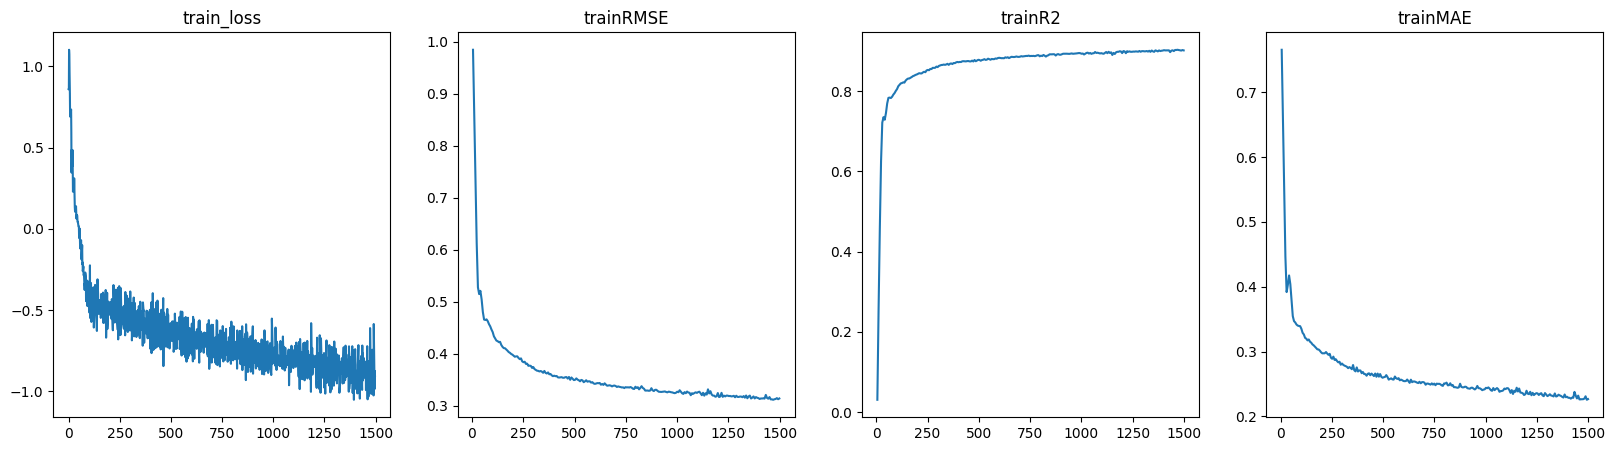

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE","trainR2","trainMAE"]
)

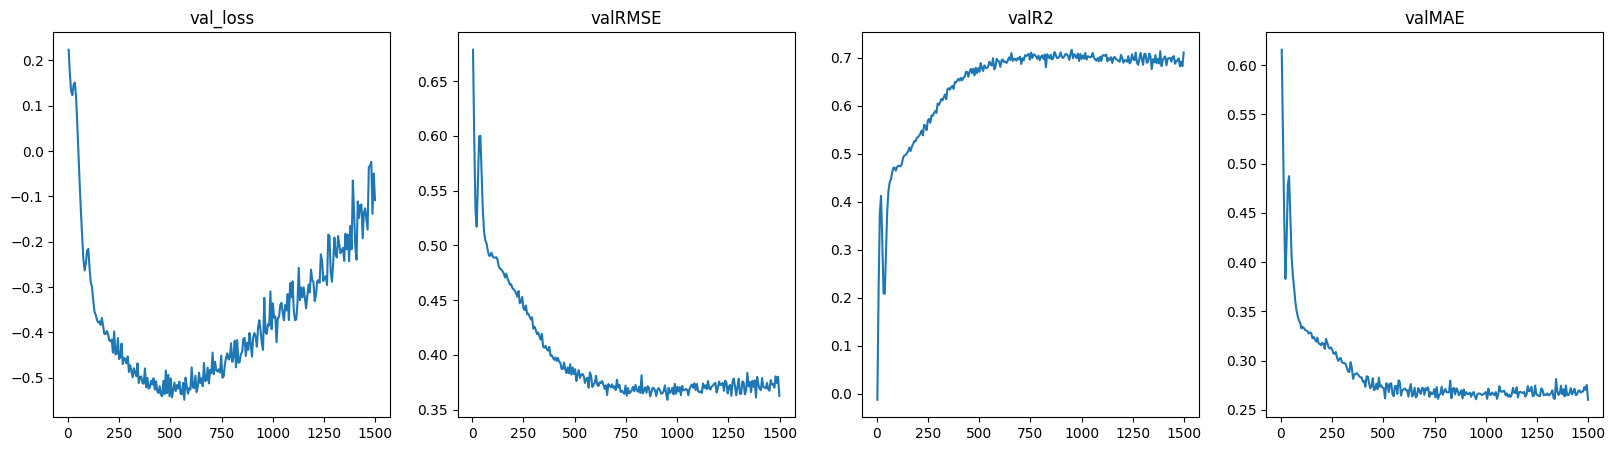

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["val_loss", "valRMSE","valR2","valMAE"]
)

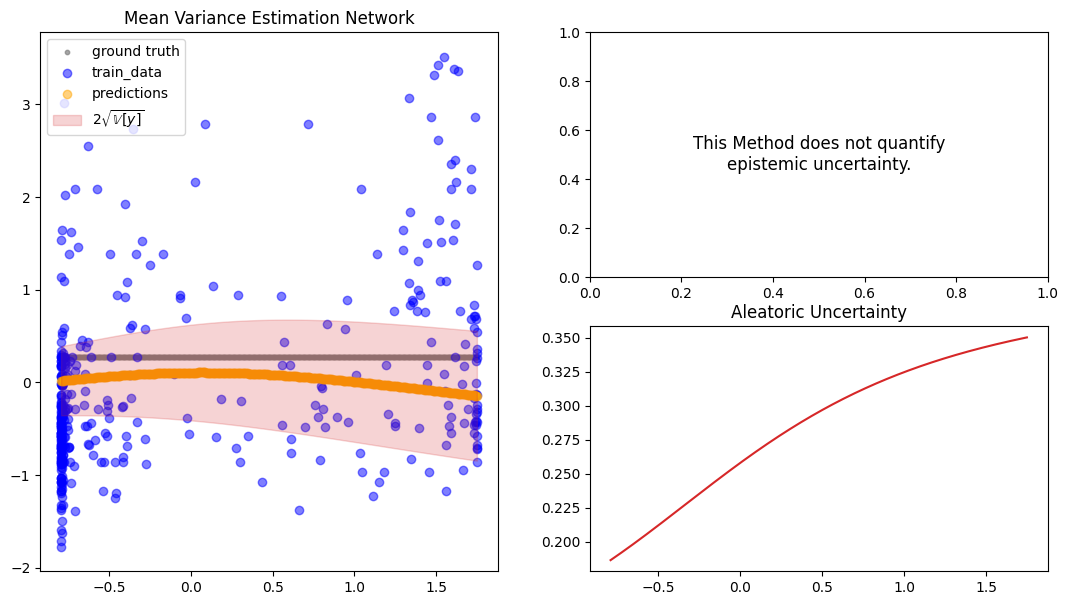

In [ ]:
preds = mve_model.predict_step(X_gtext)

fig = plot_predictions_regression(
    X_train[:,3],
    Y_train,
    X_gtext[:,3],
    Y_gtext,
    preds["pred"],
    preds["pred_uct"].squeeze(-1),
    aleatoric=preds["aleatoric_uct"],
    title="Mean Variance Estimation Network",
    show_bands=False,
)

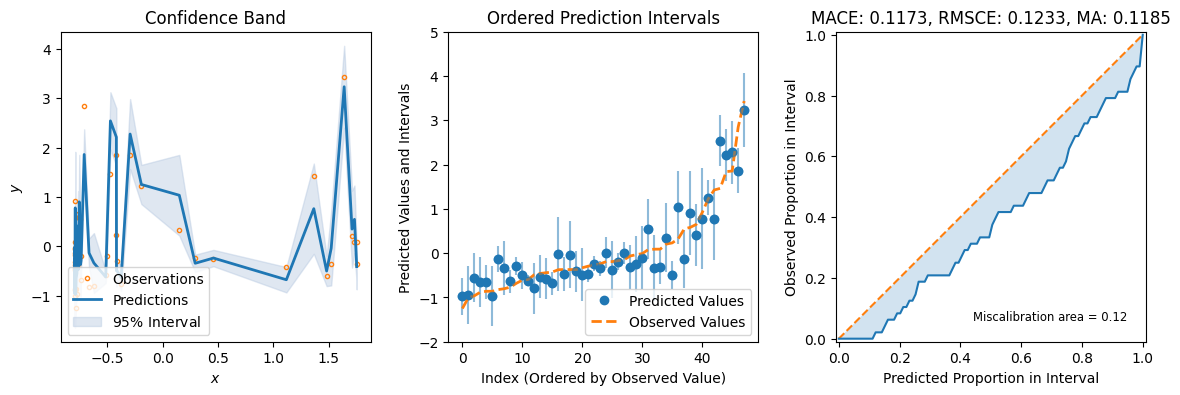

In [ ]:
preds = mve_model.predict_step(X_test)

fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    Y_test.cpu().numpy(),
    X_test[:,3].cpu().numpy(),
)

## Gaussian Process Regression

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# initialize the likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# init the GP model
gp_model = ExactGPModel(X_train.squeeze(), Y_train.squeeze(), likelihood)

# Find optimal model hyperparameters
gp_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(
    gp_model.parameters(), lr=1e-2
)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

bar = tqdm(range(100))
for i in bar:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gp_model(X_train.squeeze())
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train.squeeze())
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f"{loss.detach().cpu().item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
gp_model.eval()
likelihood.eval()

with torch.no_grad():
    gp_preds = gp_model(X_gtext.cpu())

gp_mean = gp_preds.mean.detach().cpu().numpy()
gp_var = gp_preds.variance.detach().cpu().numpy()
gp_covar = gp_preds.covariance_matrix.detach().cpu().numpy()

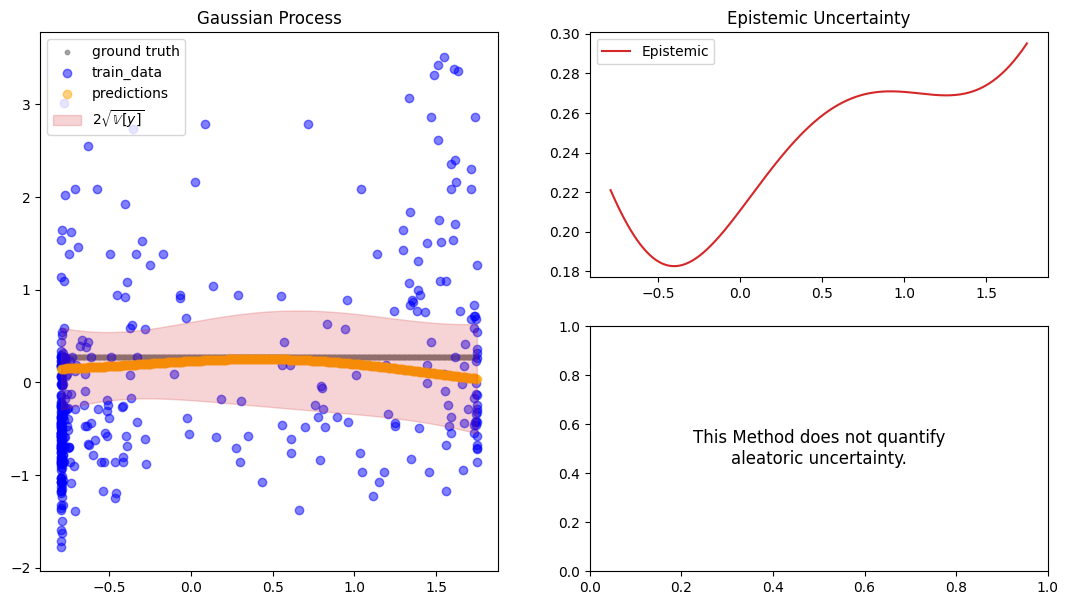

In [ ]:
fig = plot_predictions_regression(
    X_train[:,3],
    Y_train,
    X_gtext[:,3],
    Y_gtext,
    gp_mean[:, None],
    np.sqrt(gp_var),
    epistemic=np.sqrt(gp_var),
    title="Gaussian Process",
    show_bands=False,
)

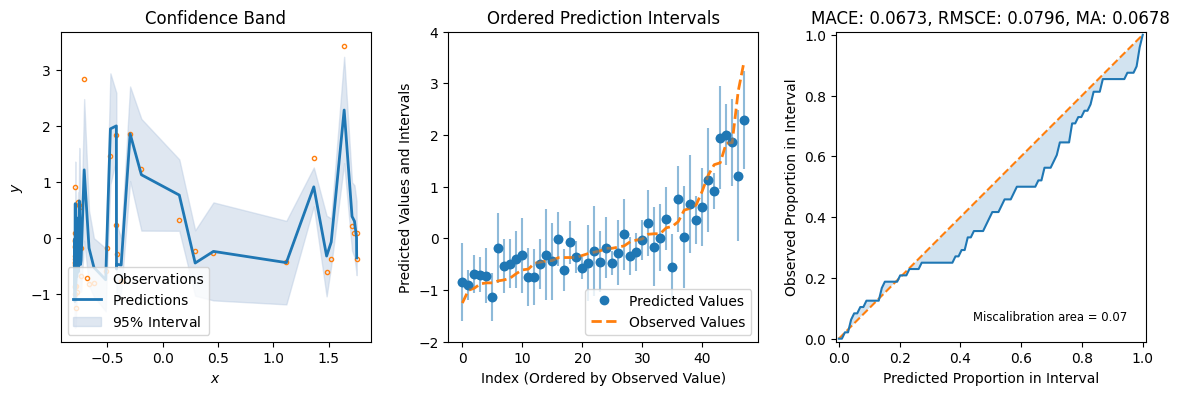

In [ ]:
with torch.no_grad():
    gp_preds = gp_model(X_test.cpu())

gp_mean = gp_preds.mean.detach().cpu().numpy()
gp_var = gp_preds.variance.detach().cpu().numpy()
gp_covar = gp_preds.covariance_matrix.detach().cpu().numpy()

fig = plot_calibration_uq_toolbox(
    gp_mean, np.sqrt(gp_var), Y_test.cpu().numpy(), X_test[:,3].cpu().numpy()
)

## Laplace Approximation

In [ ]:
network = MLP(n_inputs=13, n_hidden=[50, 50], n_outputs=1, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [ ]:
deterministic_model = DeterministicRegression(
    model=network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    loss_fn=torch.nn.MSELoss(),
)

In [ ]:
my_temp_dir = '/content/laplace'

In [ ]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(deterministic_model, dm)

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 3.3 K  | train
1 | loss_fn       | MSELoss          | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 3.3 K  | train
1 | loss_fn       | MSELoss          | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollec

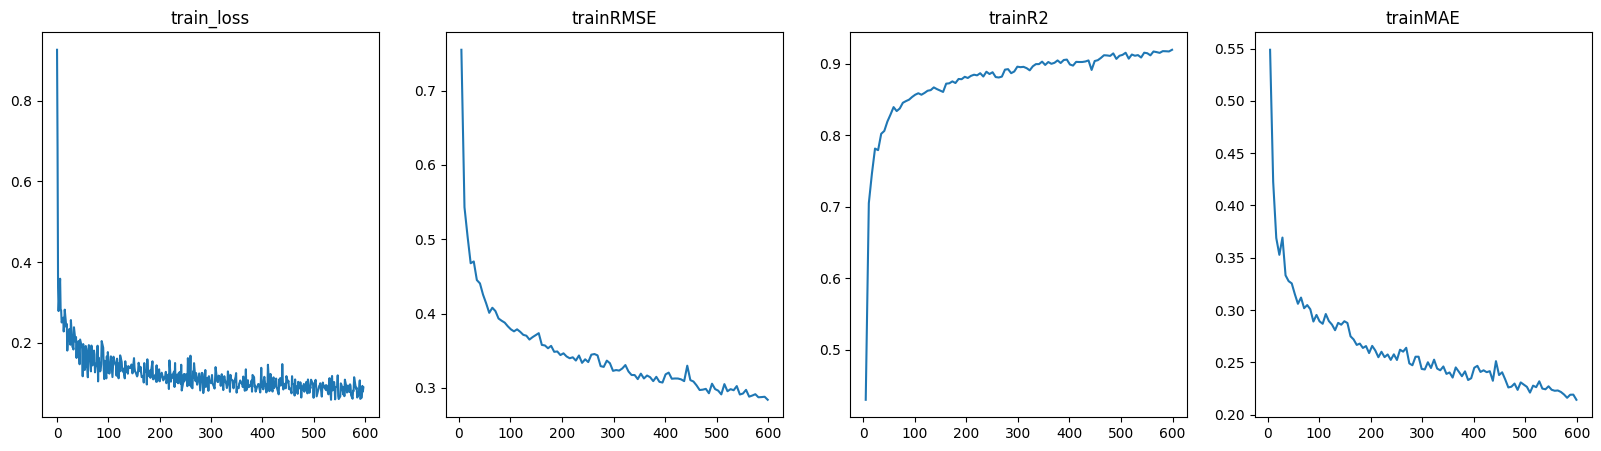

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE","trainR2","trainMAE"]
)

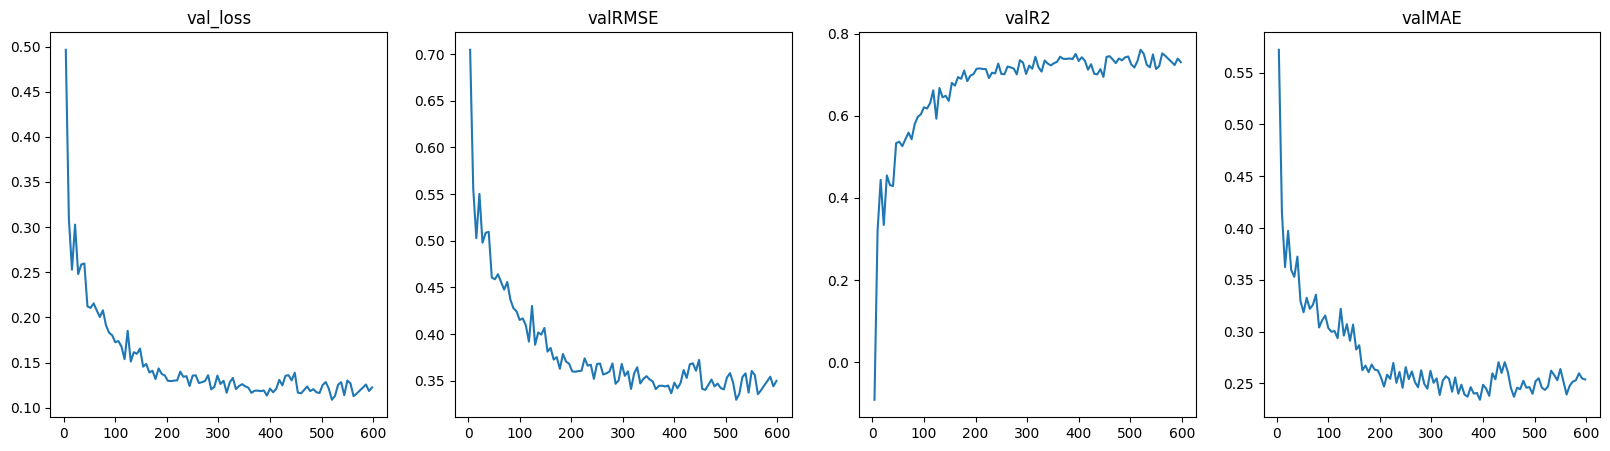

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["val_loss", "valRMSE","valR2","valMAE"]
)

In [ ]:
la = Laplace(
    deterministic_model.model,
    "regression",
    subset_of_weights="last_layer",
    hessian_structure="full",
    sigma_noise=0.4,
)


laplace_model = LaplaceRegression(laplace_model=la, tune_prior_precision=True)

trainer = Trainer(default_root_dir=my_temp_dir)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.test(laplace_model, dm)

Testing: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 100/100 [00:03<00:00, 30.36it/s, neg_marglik=149.81980895996094]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          testMAE          │    0.2795061767101288     │
│          testR2           │    0.8658266067504883     │
│         testRMSE          │     0.354962557554245     │
│         test_loss         │    0.12599840760231018    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.12599840760231018,
  'testMAE': 0.2795061767101288,
  'testR2': 0.8658266067504883,
  'testRMSE': 0.354962557554245}]

In [ ]:
preds = laplace_model.predict_step(X_test)

fig = plot_predictions_regression(
    X_train[:,3],
    Y_train,
    X_test[:,3],
    Y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="Laplace Approximation",
)

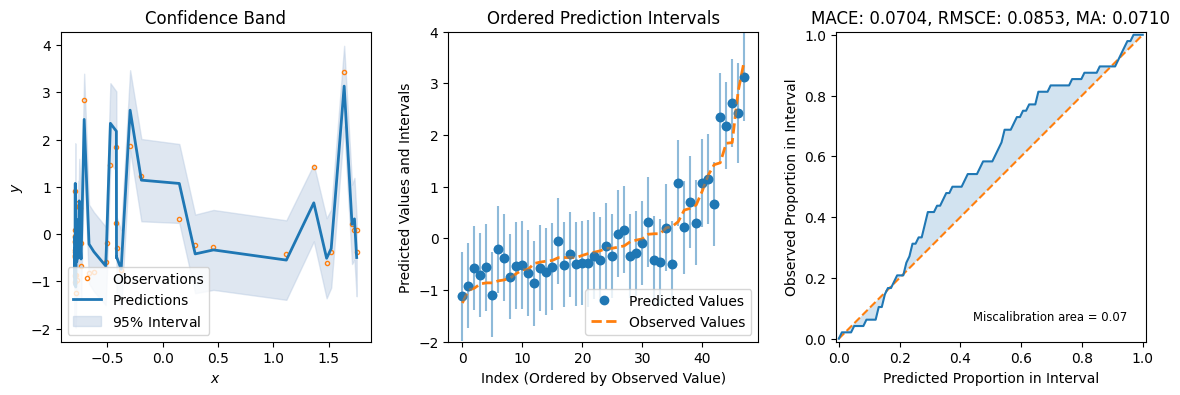

In [ ]:
preds = laplace_model.predict_step(X_test)
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].numpy(),
    Y_test.cpu().numpy(),
    X_test[:,3].cpu().numpy(),
)

In [ ]:
sample_preds = laplace_model.predict_step(param_values)

In [ ]:
Si = sobol.analyze(problem, sample_preds["pred"].cpu().numpy())

/usr/local/lib/python3.11/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


### Plot Variance Based Sensitivity Analysis

In [ ]:
def plot_sensitivity_indices(Si, feature_names):
    """Plot the first-order and total sensitivity indices."""
    s1 = Si['S1']
    st = Si['ST']
    indices = range(len(s1))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(indices, s1)
    plt.xticks(indices, feature_names, rotation=90)
    plt.title('First-order Sensitivity Indices')
    plt.ylabel('S1')

    plt.subplot(1, 2, 2)
    plt.bar(indices, st)
    plt.xticks(indices, feature_names, rotation=90)
    plt.title('Total Sensitivity Indices')
    plt.ylabel('ST')

    plt.tight_layout()
    plt.show()

In [ ]:
import random

def plot_feature_variance_and_interactions(X, y, Si, feature_names, sample_fraction=0.5):
    """
    Plot the variance of each feature with respect to the probability score
    and the strongest interactions, randomly hiding scatter dots for clarity.

    Args:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Target values.
        Si (dict): Sensitivity indices.
        feature_names (list): List of feature names.
        sample_fraction (float): Fraction of points to display in scatter plot (default is 50%).
    """
    s1 = Si['S1']
    st = Si['ST']
    s2 = Si['S2']

    for i, feature in enumerate(feature_names):
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Randomly sample a fraction of points for the scatter plot
        total_samples = X.shape[0]
        sample_size = int(sample_fraction * total_samples)
        sample_indices = random.sample(range(total_samples), sample_size)
        sampled_X = X[sample_indices, i]
        sampled_y = y[sample_indices]

        # Plot first-order sensitivity index
        sns.scatterplot(x=sampled_X, y=sampled_y, ax=ax[0])
        ax[0].set_title(f'Variance Contribution of {feature}', fontsize=14)
        ax[0].set_xlabel(feature, fontsize=12)
        ax[0].set_ylabel('lg_price', fontsize=12)
        ax[0].tick_params(axis='x', rotation=45)
        ax[0].tick_params(axis='y', labelsize=10)

        # Calculate interaction strengths for the current feature
        interaction_strengths = []
        for j, other_feature in enumerate(feature_names):
            if i != j:
                interaction_strength = s2[i, j] if s2.ndim > 1 else 0
                interaction_strengths.append((other_feature, interaction_strength))

        # Sort by interaction strength and select top 5 for the current feature
        interaction_strengths.sort(key=lambda x: abs(x[1]), reverse=True)
        top_interactions = interaction_strengths

        interaction_features = [item[0] for item in top_interactions]
        interaction_values = [item[1] for item in top_interactions]

        # Use a colormap to assign colors
        cmap = get_cmap('coolwarm_r')  # '_r' inverts the colormap
        colors = [cmap(i / len(interaction_features)) for i in range(len(interaction_features))]

        sns.barplot(x=interaction_features, y=interaction_values, ax=ax[1], palette=colors)
        ax[1].set_title(f'Strongest Interactions with {feature}', fontsize=14)
        ax[1].set_xlabel('Feature', fontsize=12)
        ax[1].set_ylabel('Interaction Strength', fontsize=12)
        ax[1].tick_params(axis='x', rotation=45, labelsize=10)
        ax[1].tick_params(axis='y', labelsize=10)

        plt.tight_layout()
        plt.show()


### Continue Analyzing

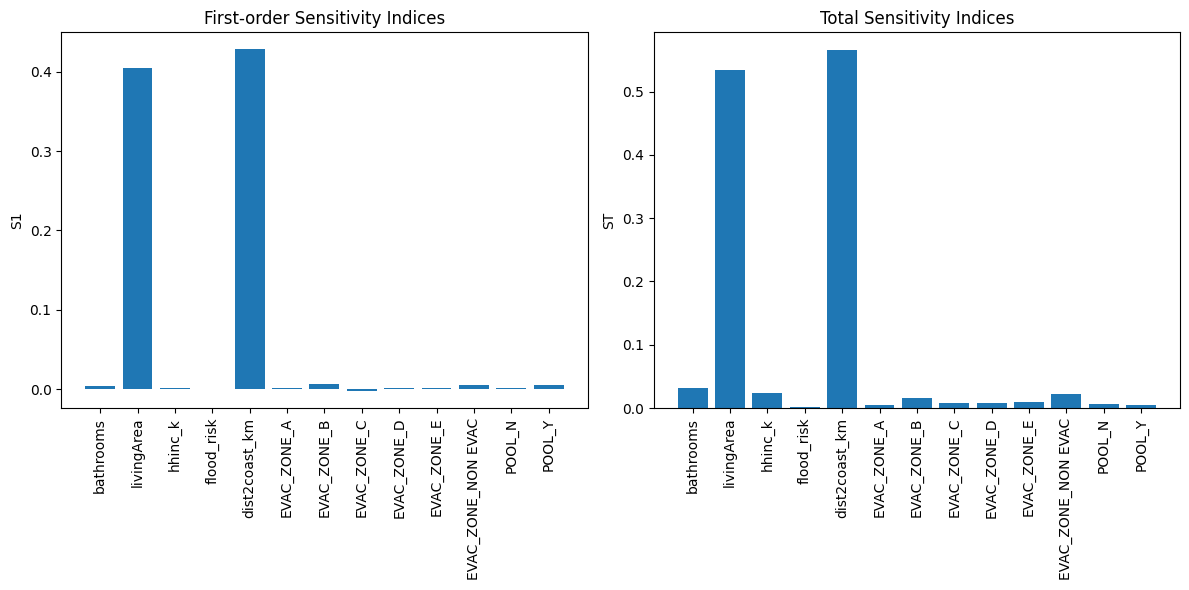

In [ ]:
plot_sensitivity_indices(Si, all_feature_names)

In [ ]:
plot_feature_variance_and_interactions(param_values, sample_preds["pred"].cpu().numpy(), Si, all_feature_names, sample_fraction=0.1)

## Bayes By Backprop - Mean Field Variational Inference

In [ ]:
network = MLP(n_inputs=13, n_hidden=[50, 50], n_outputs=2, activation_fn=nn.ReLU())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [ ]:
bbp_model = BNN_VI_ELBO_Regression(
    network,
    optimizer=partial(torch.optim.Adam, lr=3e-3),
    criterion=NLL(),
    stochastic_module_names=[-1],
    num_mc_samples_train=10,
    num_mc_samples_test=25,
    burnin_epochs=20,
)

In [ ]:
my_temp_dir = '/content/bbp'

In [ ]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=150,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=20,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(bbp_model, dm)

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 3.5 K  | train
1 | loss_fn       | NLL              | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 3.5 K  | train
1 | loss_fn       | NLL              | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollec

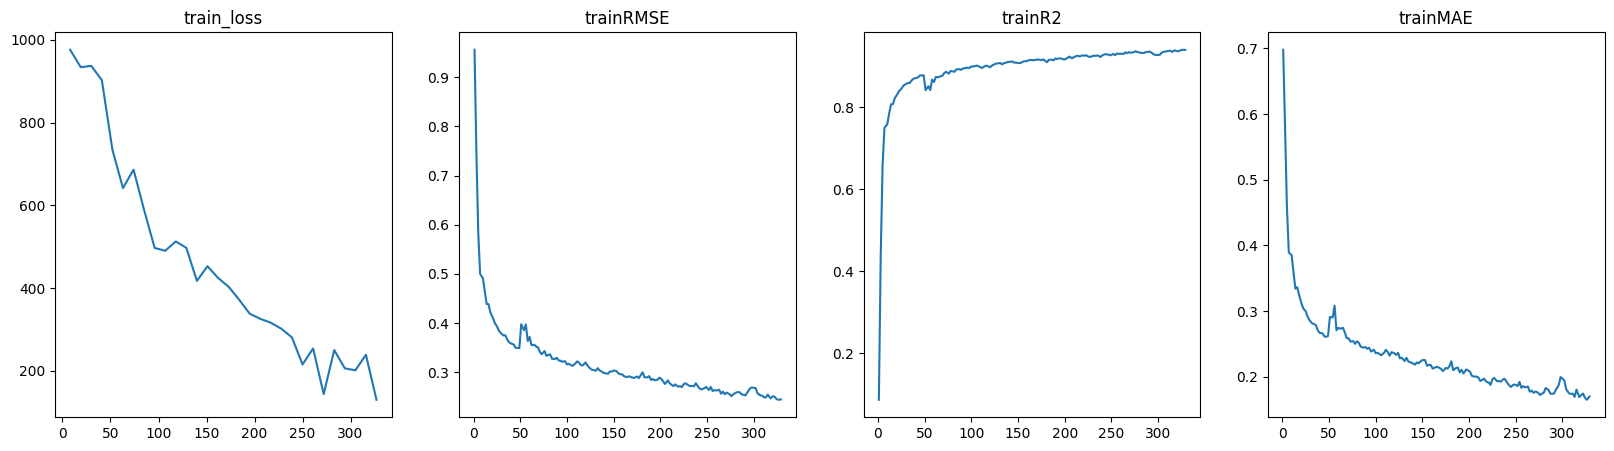

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE","trainR2","trainMAE"]
)

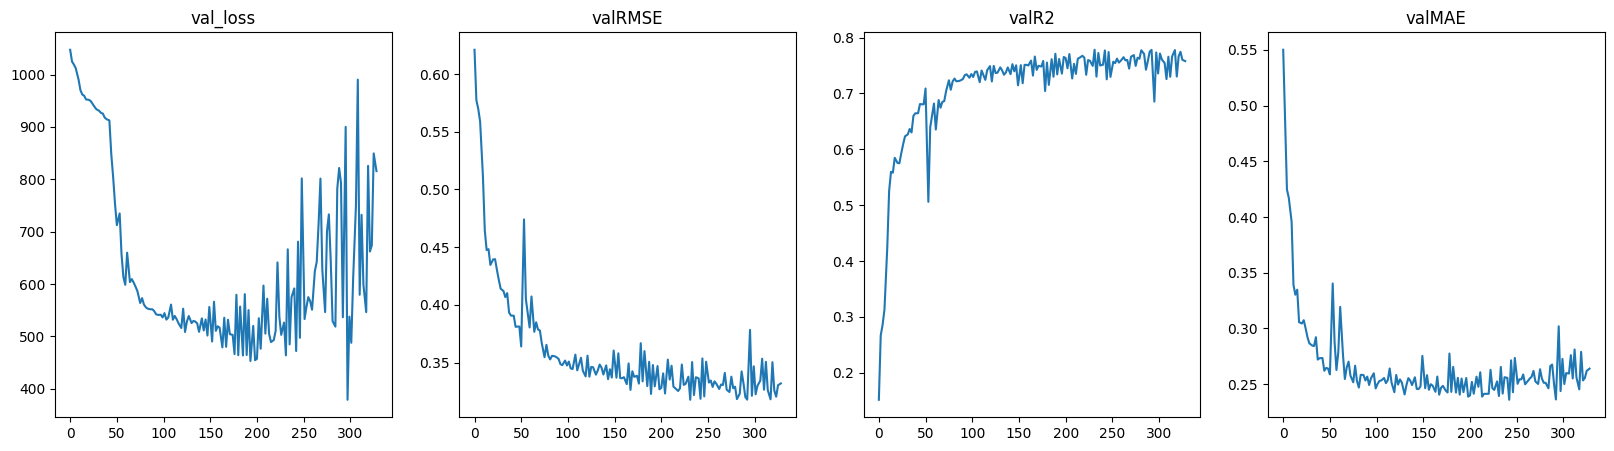

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["val_loss", "valRMSE","valR2","valMAE"]
)

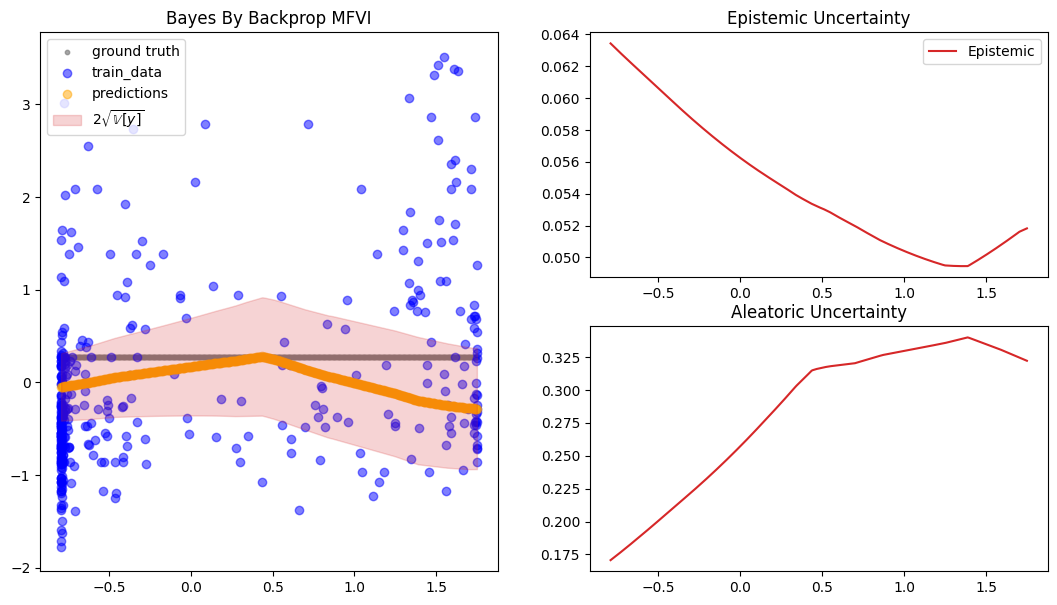

In [ ]:
preds = bbp_model.predict_step(X_gtext)

fig = plot_predictions_regression(
    X_train[:,3],
    Y_train,
    X_gtext[:,3],
    Y_gtext,
    preds["pred"].squeeze(-1),
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="Bayes By Backprop MFVI",
    show_bands=False,
)

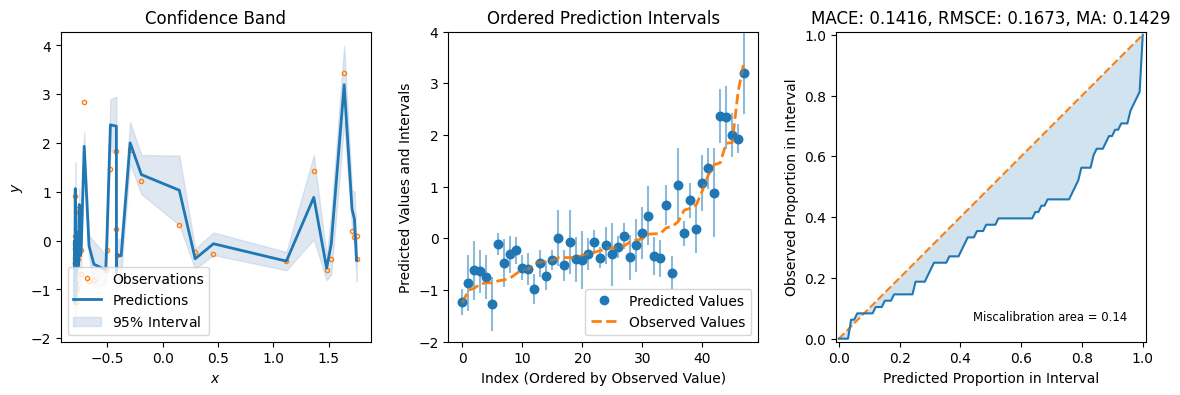

In [ ]:
preds = bbp_model.predict_step(X_test)
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    Y_test.cpu().numpy(),
    X_test[:,3].cpu().numpy(),
)

## Bayesian Neural Network with Variational Inference and Energy Loss

In [ ]:
network = MLP(n_inputs=8, n_hidden=[50, 50], n_outputs=1, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [ ]:
bnn_vi_model = BNN_VI_Regression(
    network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    n_mc_samples_train=10,
    n_mc_samples_test=50,
    output_noise_scale=1.3,
    prior_mu=0.0,
    prior_sigma=1.0,
    posterior_mu_init=0.0,
    posterior_rho_init=-6.0,
    alpha=1e-03,
    bayesian_layer_type="reparameterization",
    stochastic_module_names=[-1],
)

In [ ]:
my_temp_dir = '/content/bnn_vi'

In [ ]:
logger = CSVLogger(my_temp_dir)

# Define early stopping callback
early_stop_callback = EarlyStopping(
    monitor='valRMSE',  # You can change this to another metric like 'val_accuracy'
    patience=10,  # Number of epochs with no improvement before stopping
    verbose=False,  # Print when early stopping is triggered
    mode='min',  # 'min' means we are looking for a decrease in the metric (e.g., val_loss)
)

trainer = Trainer(
    max_epochs=200,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=False,
    limit_val_batches=1.0,  # full validation runs
    default_root_dir=my_temp_dir,
    callbacks=[early_stop_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


In [ ]:
trainer.fit(bnn_vi_model, dm)

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 3.1 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | nll_loss      | GaussianNLLLoss  | 0      | train
  | other params  | n/a              | 1      | n/a  
-----------------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 3.1 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

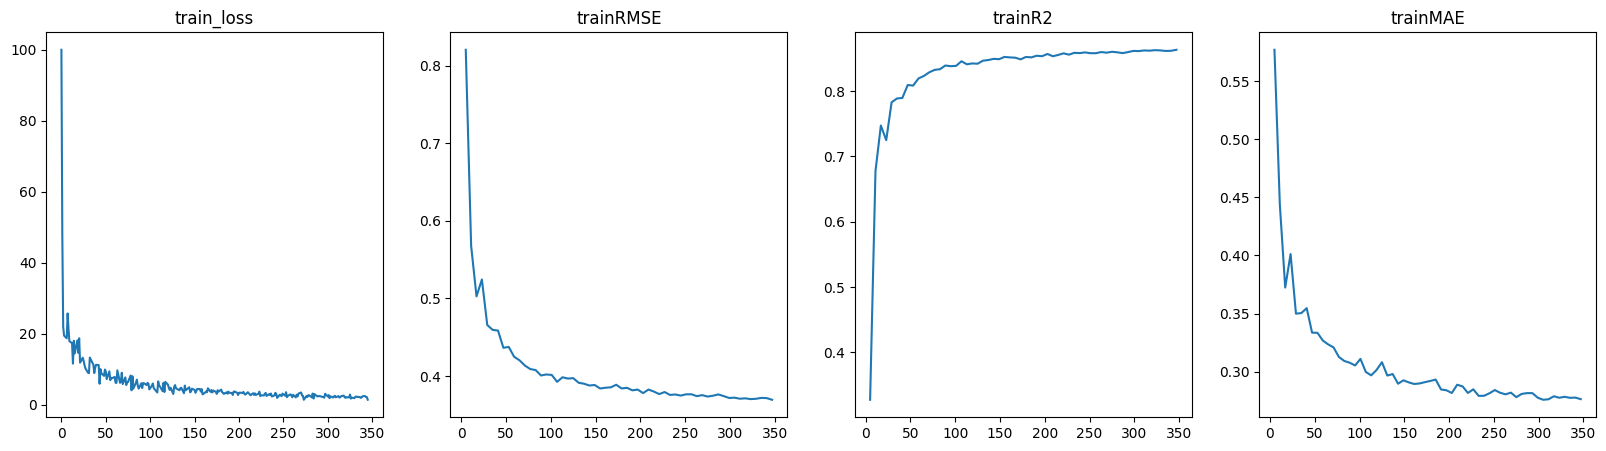

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE","trainR2","trainMAE"]
)

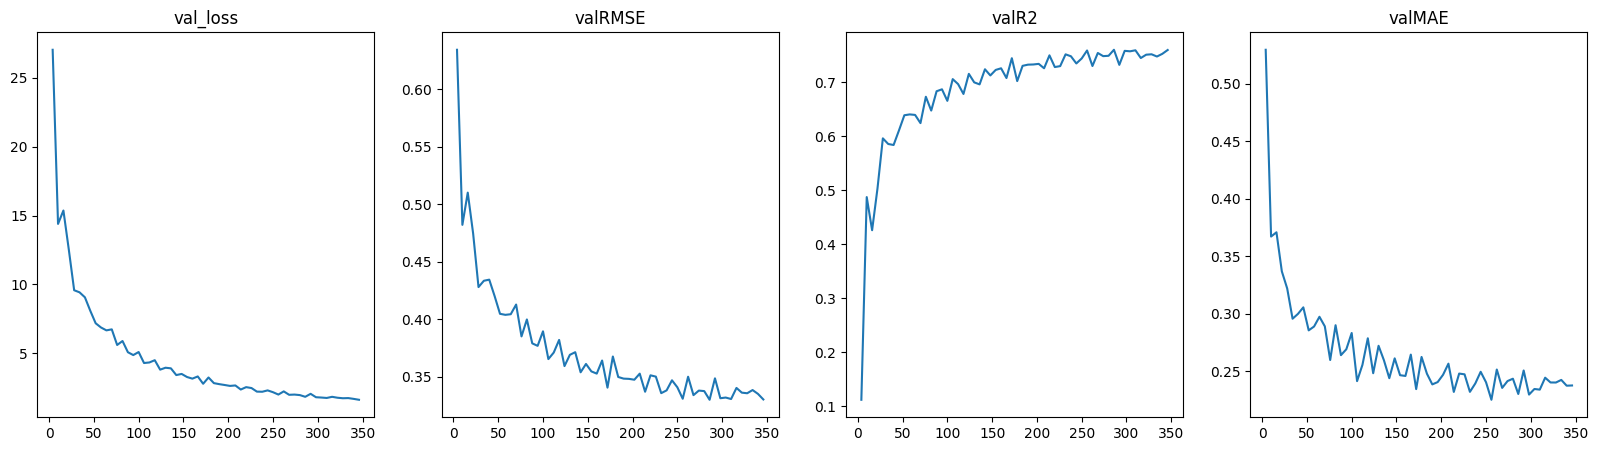

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["val_loss", "valRMSE","valR2","valMAE"]
)

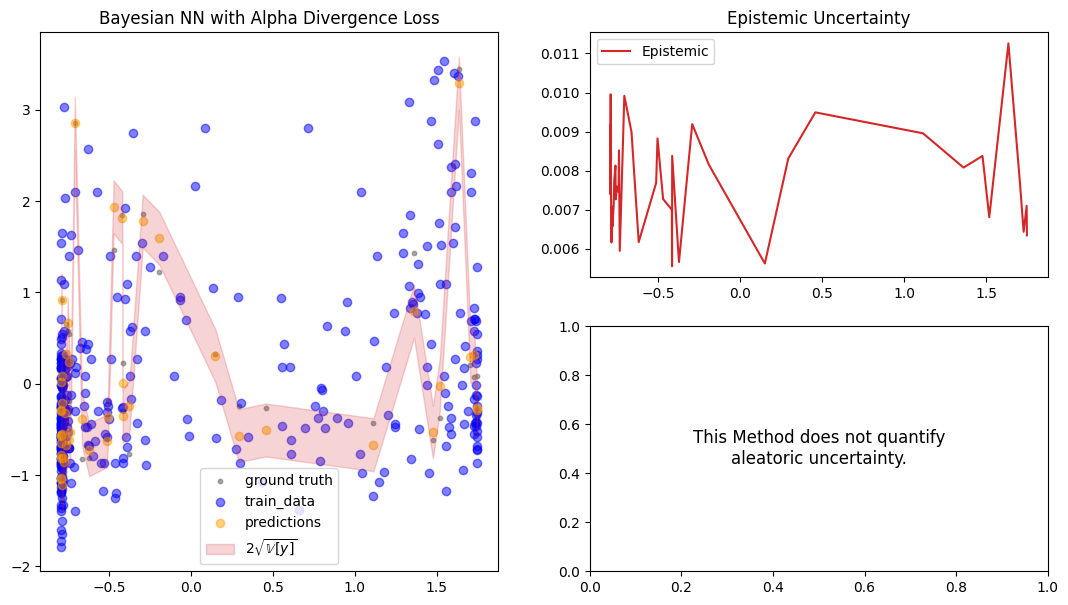

In [ ]:
preds = bnn_vi_model.predict_step(X_test)

fig = plot_predictions_regression(
    X_train[:,3],
    Y_train,
    X_test[:,3],
    Y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    show_bands=False,
    title="Bayesian NN with Alpha Divergence Loss",
)

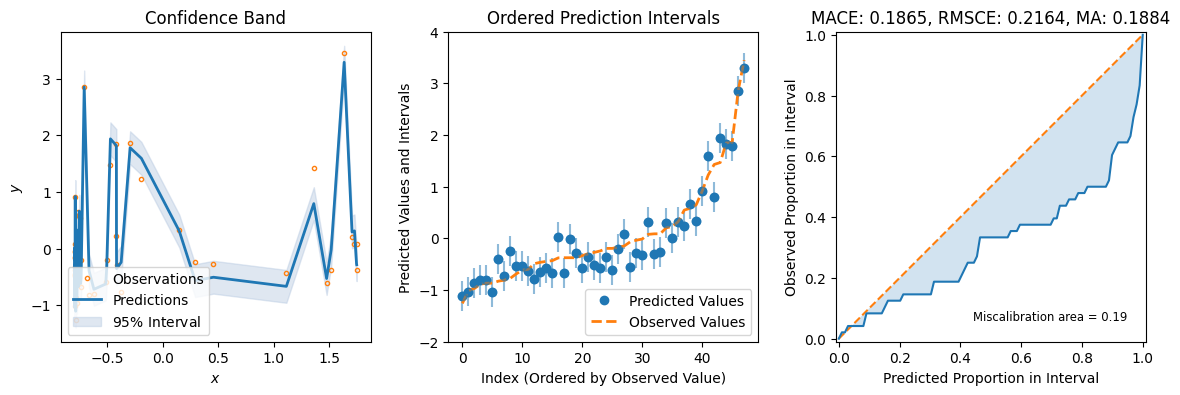

In [ ]:
preds = bnn_vi_model.predict_step(X_test)
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    Y_test.cpu().numpy(),
    X_test[:,3].cpu().numpy(),
)

In [ ]:
pred_mean = preds["pred"].cpu().numpy().squeeze()
pred_std = preds["pred_uct"].cpu().numpy()
te_y = np.squeeze(Y_test.cpu().numpy())

<Axes: title={'center': 'Adversarial Group Calibration'}, xlabel='Group size', ylabel='Calibration Error of Worst Group'>

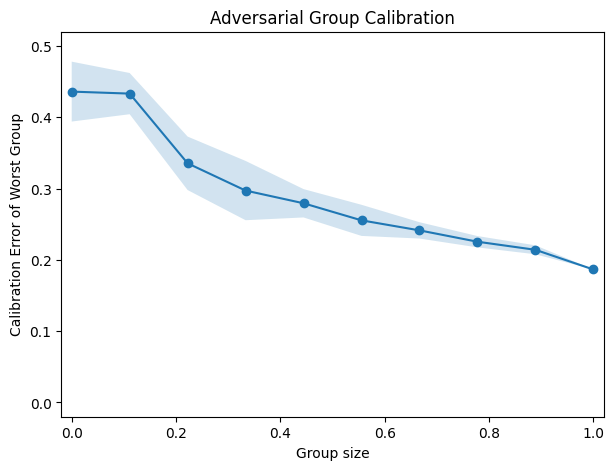

In [ ]:
# Plot adversarial group calibration
uct.viz.plot_adversarial_group_calibration(preds["pred"].cpu().numpy().squeeze(), preds["pred_uct"].cpu().numpy(), np.squeeze(Y_test.cpu().numpy()))

In [ ]:
uct.metrics.get_all_metrics(preds["pred"].cpu().numpy().squeeze(), preds["pred_uct"].cpu().numpy(), np.squeeze(Y_test.cpu().numpy()))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  8.02it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.217
  RMSE          0.267
  MDAE          0.208
  MARPD         63.131
  R2            0.925
  Correlation   0.964
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.216
  Mean-absolute Calibration Error       0.187
  Miscalibration Area                   0.188
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.378
     Group Size: 0.56 -- Calibration Error: 0.242
     Group Size: 1.00 -- Calibration Error: 0.187
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.436
     Group Size: 0.56 -- Calibration Error: 0.286
     Group Size: 1.00 -- Calibration Error: 0.216
===============

{'accuracy': {'mae': 0.21736419200897217,
  'rmse': 0.2674989374309007,
  'mdae': 0.20796074,
  'marpd': 63.13146948814392,
  'r2': 0.9245057702064514,
  'corr': 0.9637017440406118},
 'avg_calibration': {'rms_cal': 0.2163504758698047,
  'ma_cal': 0.1865214646464647,
  'miscal_area': 0.18839436026936035},
 'adv_group_calibration': {'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
   'adv_group_cali_mean': array([0.45710101, 0.37780404, 0.31581818, 0.29880114, 0.27725685,
          0.24164983, 0.23499527, 0.22867267, 0.20961475, 0.18652146]),
   'adv_group_cali_stderr': array([2.43172620e-02, 4.99419582e-02, 4.91043753e-02, 3.34852175e-02,
          1.95630878e-02, 2.54599586e-02, 1.77420558e-02, 1.74030772e-02,
          1.30443910e-02, 2.92569456e-17])},
  'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
   

In [ ]:
test_df['pred_mean'] = pred_mean
test_df['pred_std'] = pred_std
test_df['residual'] = pred_mean - te_y

In [ ]:
test_df.to_csv('test_df_flood_with_loc.csv', index=False)

In [ ]:
sample_preds = bnn_vi_model.predict_step(param_values)

In [ ]:
Si = sobol.analyze(problem, sample_preds["pred"].cpu().numpy().squeeze())

/usr/local/lib/python3.11/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


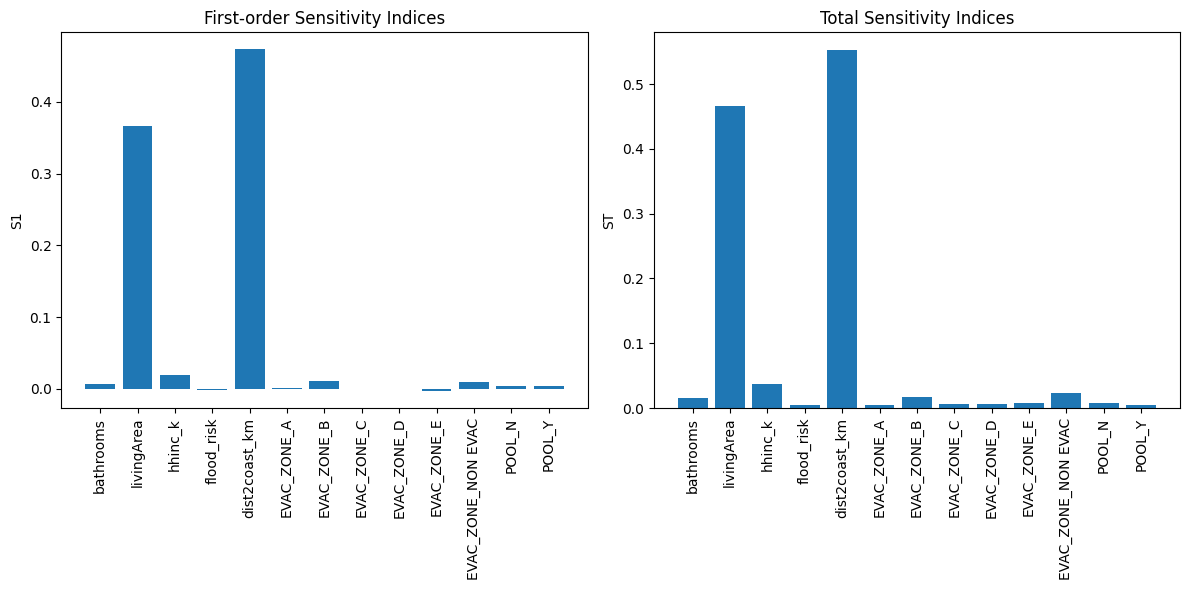

In [ ]:
plot_sensitivity_indices(Si, all_feature_names)

In [ ]:
plot_feature_variance_and_interactions(param_values, sample_preds["pred"].cpu().numpy().squeeze(), Si, all_feature_names, sample_fraction=0.1)